## LOG
#### [09/05/2020] 
- progress: completing training loop
- issues: TrainEvalCallback turns model into eval mode. It is not desired because torchvision.FasterRCNN has different behavior at eval mode
- issues: friction integrating metrics into the training loop
- issues: default datablock is not really suitable for torchvision.FasterRCNN

#### [10/05/2020]
- minor issue: train.json has duplicates dict in key 'images'

#### [17/05/2020]
- metrics has been integrated in training loop
- changed to RetinaNet from torchvision.FasterRCNN
- some data has a large bboxes

**Questions**
- in dls.show_batch, how to augment image_id on plot?
- how TensorBBox is transforms in batch?
- why RetinaNet classifier score is negative (no matter class = 1 OR 2)

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dblock import build_dblock
from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.metrics.mAP import mAP

%load_ext autoreload
%autoreload 2

In [2]:
from pdb import set_trace

In [3]:
data_path = '/userhome/34/h3509807/wheat-data'

#### -1. Sanity Check ```train.json```

In [4]:
from src.data.utils import decode_coco_json

In [5]:
json_path = Path(data_path) / 'train_mini.json'
img_ids, lbl_bbox, img2bbox = decode_coco_json(json_path)

In [6]:
len(img_ids), len(lbl_bbox), len(img2bbox)

(120, 120, 120)

#### 1a. Get DataBlock

In [7]:
dblk = build_dblock(Path(data_path), resize_sz = 256, 
                    norm = True, rand_seed = 144, test_mode = True)

In [8]:
ds = dblk.datasets(data_path + '/train')

In [9]:
xx = ds[0]
type(xx[0]), xx[0].shape, type(xx[1])

(fastai2.vision.core.PILImage, (1024, 1024), fastai2.vision.core.TensorBBox)

#### 1b. Get DataLoaders

In [10]:
dls = build_dataloaders(
    data_path, bs = 8, resize_sz = 256, 
    norm = False, rand_seed = 144, test_mode = True
    )

In [11]:
len(dls.train.items), len(dls.valid.items)

(96, 24)

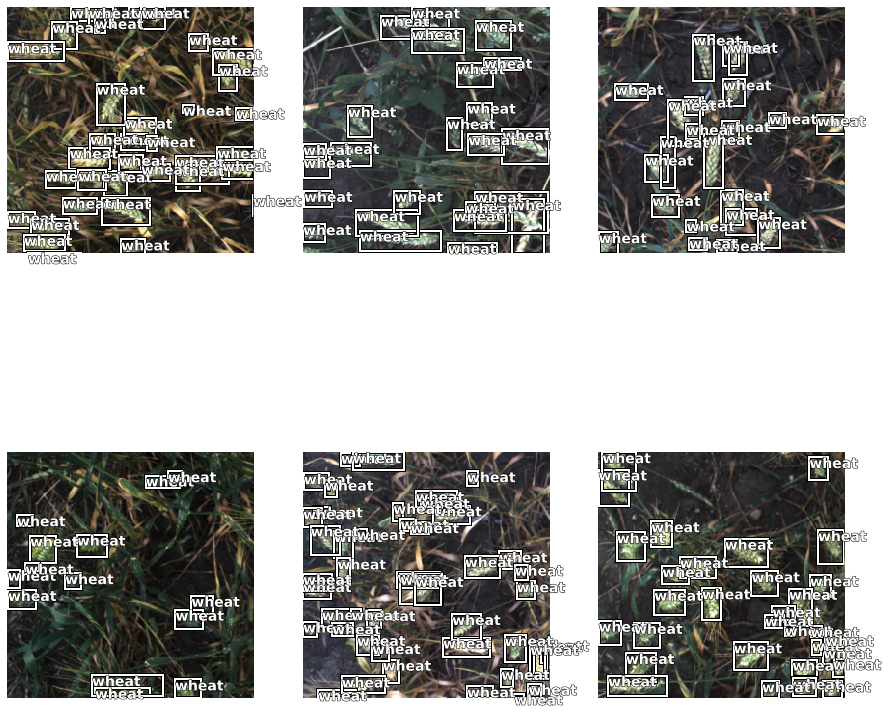

In [12]:
dls.show_batch(max_n = 6, figsize = (15, 15))

In [13]:
# batch = (TensorImage, TensorBBox, TensorMultiCategory)
# TensorBBox: [BS, MAX BBOX NUMBER, 4]
# TensorMultiCategory: [BS, MAX BBOX NUMBER]
b = dls.one_batch()
type(b), type(b[0]), type(b[1]), type(b[2])

(tuple,
 fastai2.torch_core.TensorImage,
 fastai2.vision.core.TensorBBox,
 fastai2.torch_core.TensorMultiCategory)

In [14]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 48, 4]), torch.Size([8, 48]))

In [15]:
b[0][0, 0, :3, :3]

tensor([[0.1843, 0.1961, 0.2078],
        [0.1725, 0.1843, 0.1961],
        [0.1804, 0.1804, 0.1804]], device='cuda:0')

In [16]:
b[1][0][0]

tensor([ 0.5137, -0.7871,  0.7168, -0.7188], device='cuda:0')

In [17]:
get_c(dls)

2

#### 2. Setup Model

In [18]:
import torch.nn as nn

In [19]:
model = get_retinanet()

In [20]:
for attr_name in dir(model):
    attr = getattr(model, attr_name)
    if isinstance(attr, nn.Module) or isinstance(attr, nn.Sequential):
        print(attr_name)

box_regressor
c5top5
c5top6
classifier
encoder
merges
p6top7
smoothers


#### 3. Setup Dummy Loss Function

In [21]:
retinanet_loss = get_retinanet_loss(ratios = None, scales = None)

In [22]:
retinanet_loss

RetinaNetFocalLoss()

#### 4a. Setup mAP for RetinaNet

In [41]:
b = dls.one_batch()
b_clas_gts, b_bboxs_gts, sizes = b
b_preds = model(xb)
b_clas_preds, b_bboxs_preds, sizes = b_preds

b_clas_preds.shape, b_clas_gts.shape

(torch.Size([8, 46836, 1]), torch.Size([8, 3, 256, 256]))

#### 4b. Wrap up the Whole mMAP Metrics Function

In [42]:
from functools import partial

thresholds = [i for i in map(lambda i: i/100, range(50, 80, 5))]
thresholds

map_getter = partial(mAP, thresholds = thresholds)

#### 5a. Setup Callback

#### 5b. Change TrainEvalCallback Behavior
no need activate eval mode in validation set

#### 6. Setup Learner

In [26]:
learn = Learner(dls, model, 
                loss_func = retinanet_loss, 
                splitter = split_param_groups,
                metrics = map_getter)

In [27]:
learn.freeze()

In [28]:
learn.summary()

RetinaNet (Input shape: ['8 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 128 x 128   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 128 x 128   128        True      
________________________________________________________________
ReLU                 8 x 64 x 128 x 128   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 64 x 64     0          False     
________________________________________________________________
Conv2d               8 x 64 x 64 x 64     36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 64 x 64     128        True      
________________________________________________________________
ReLU                 8 x 64 x 64 x 64     0          False     
___________________________________________________

#### 7. Find Optimal Learning Rate

In [29]:
#learn.lr_find()

#### 8. Train The Head

In [31]:
lr = 1e-4
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,mAP,time
0,2.308137,2.046375,None,12:04


> /userhome/34/h3509807/Wheat-Detection-2020/src/metrics/mAP.py(37)mAP()
-> met = calculate_image_precision(gts, preds, thresholds, form)
(Pdb) l
 32  	
 33  	        # filter out preds below detection threshold
 34  	
 35  	        # restore predicted bbox
 36  	
 37  ->	        met = calculate_image_precision(gts, preds, thresholds, form)
 38  	        b_mets.append(met)
 39  	
 40  	    return sum(b_mets) / len(b_mets)
 41  	
 42  	
(Pdb) clas_preds.shape
torch.Size([46836, 1])
(Pdb) import torch
(Pdb) xxx = clas_preds.squeeze()
(Pdb) xxx.shape
torch.Size([46836])
(Pdb) torch.argwhere(xxx > 0.5)
*** AttributeError: module 'torch' has no attribute 'argwhere'
(Pdb) xxx = clas_preds.numpy()
*** TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
(Pdb) xxx = clas_preds.cpu().numpy()
(Pdb) np
<module 'numpy' from '/userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/numpy/__init__.py'>
(Pdb) np.argwhere(xxx > 0.5)
a

BdbQuit: 

In [ ]:
%debug

#### 9. Find Optimal Learning Rate for Fine-tuning

In [36]:
learn.unfreeze()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=3.311311274956097e-06)

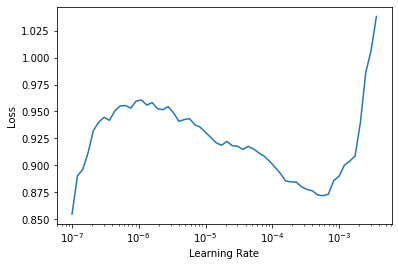

In [37]:
learn.lr_find()

#### Appendix

In [38]:
# learn.create_opt()
# learn.opt.freeze_to(-1) # freeze except last param groups
# learn.opt.param_groups[-1]
# learn.opt.freeze_to(-2) # freeze except last two param groups
# learn.opt.param_groups[-2]